In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'square'
n_classes = 6  # 6
budget = 100
n_exps = 20

# data = 'citeseer'
# n_classes = 5  # 5
# budget = 500
# n_exps = 20

# data = 'bmg'
# n_classes = 2
# budget = 500
# n_exps = 20

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    'round robin greedy',
]
if n_classes == 2 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
ucb_beta = 3
utility_function = log_utility

init_size = 1
group_size = n_classes - 1

basepath = os.path.join('../../data/results', data, str(group_size))


utilities = np.ones((len(policies), n_exps, budget + init_size)) * -1

for p_ind, policy in enumerate(policies):
    folder = policy
    if policy.endswith('ucb'):
        folder += f' {ucb_beta}'
    
    for i in range(n_exps):
        labels = np.loadtxt(
            os.path.join(basepath, folder, f'{policy}__labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1

        utilities[p_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities[..., -1].mean(axis=1)

array([14.25253017, 11.88285983, 13.1434988 , 12.42719422])

ens jensen greedy: 14.2525
classical ens: 11.8829
greedy: 13.1435
round robin greedy: 12.4272


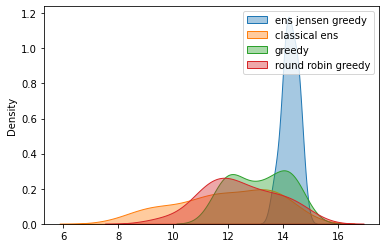

In [4]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, :, -1], alpha=0.4, shade=True, label=policy)
    
plt.legend();

In [5]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if utilities[p1, :, -1].mean() < utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                utilities[p1, :, -1], 
                utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    
    print()

ens jensen greedy vs. classical ens
1.0475782316091197e-06
ens jensen greedy vs. greedy
8.363291659280985e-05
ens jensen greedy vs. round robin greedy
8.320309553470553e-07

classical ens vs. greedy
0.011240327145763191
classical ens vs. round robin greedy
0.07651931355438167

greedy vs. round robin greedy
0.028388957275488843



14.117251846766148 14.387808490373782
0.0676
11.08246462198244 12.683255036760654
0.4002
12.670571628419196 13.616425970549205
0.2365
11.80291474105453 13.05147369588093
0.3121


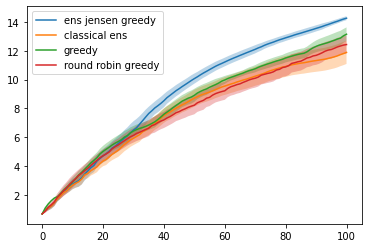

In [6]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.4f}')
    
plt.legend();